**GW19_PFC_all**

# Libraries

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import triku as tk

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.8 anndata==0.9.2 umap==0.5.3 numpy==1.21.1 scipy==1.8.0 pandas==1.2.4 scikit-learn==1.1.1 statsmodels==0.13.2 igraph==0.9.10 pynndescent==0.5.7


In [3]:
results_file = '/group/testa/Project/CBOProgPools/h5ad/GW19_02_20240209_v1.h5ad'  # the file that will store the analysis results

In [4]:
geschwind_ext = {
  'astrocytes' : ['S100B','AQP4'],
  'pericyte' : ['RGS5'],
  'microglia' : ['AIF1'],
  'endothelial' : ['ITM2A','CLDN5','ESAM'],
  'ExcDeepLayer' : ['SOX5'],
  'Interneurons' : ['DLX1','DLX2','DLX5'],
  'MatUpperEnr' : ['STMN2','SATB2','LMO4'],
  'IP' : ['PPP1R17','SSTR2','EOMES','PENK'],
  'MatExc' : ['SATB2','STMN2'],
  'MigExc' : ['POU3F2'],
  'CycProg' : ['HMGB2','SOX2','MKI67','PCNA'],
  'OPCs' : ['PTPRZ1','OLIG1','PDGFRA'],
  'RG' : ['VIM','PTPRZ1','SOX2','SLC1A3','HES1','HOPX'],
  'Exc_CAMK2A+' : ['CAMK2A'],
  'Exc_TBR1+' : ['TBR1']
}

In [5]:
# Read in the count matrix into an AnnData object, which holds many slots for annotations and different representations
# of the data. It also comes with its own HDF5-based file format: .h5ad.
adata = sc.read_10x_mtx(
    '/group/testa/Project/CBOProgPools/data/GW19_PFC_all/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

... reading from cache file cache/group-testa-Project-CBOProgPools-data-GW19_PFC_all-matrix.h5ad


In [6]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [7]:
adata

AnnData object with n_obs × n_vars = 3910 × 33694
    var: 'gene_ids'

# Data Preparation

normalizing counts per cell
    finished (0:00:00)


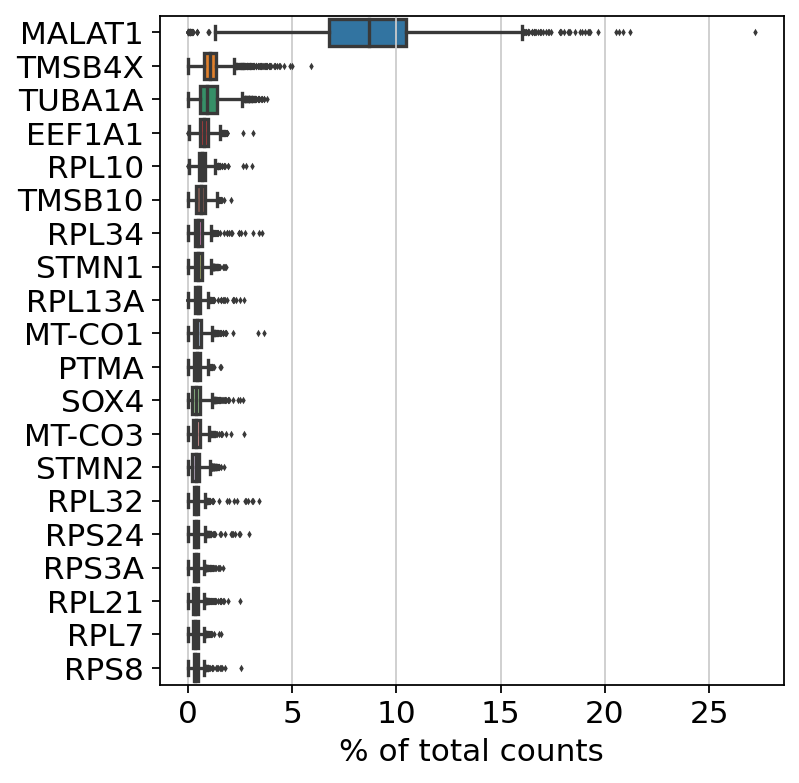

In [8]:
# Show those genes that yield the highest fraction of counts in each single cell, across all cells.
sc.pl.highest_expr_genes(adata, n_top=20, )


In [9]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=50)

filtered out 1 cells that have less than 100 genes expressed
filtered out 22569 genes that are detected in less than 50 cells


In [10]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

adata.var['ribo'] = adata.var_names.str.startswith('RPL')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['ribo'], percent_top=None, log1p=False, inplace=True)

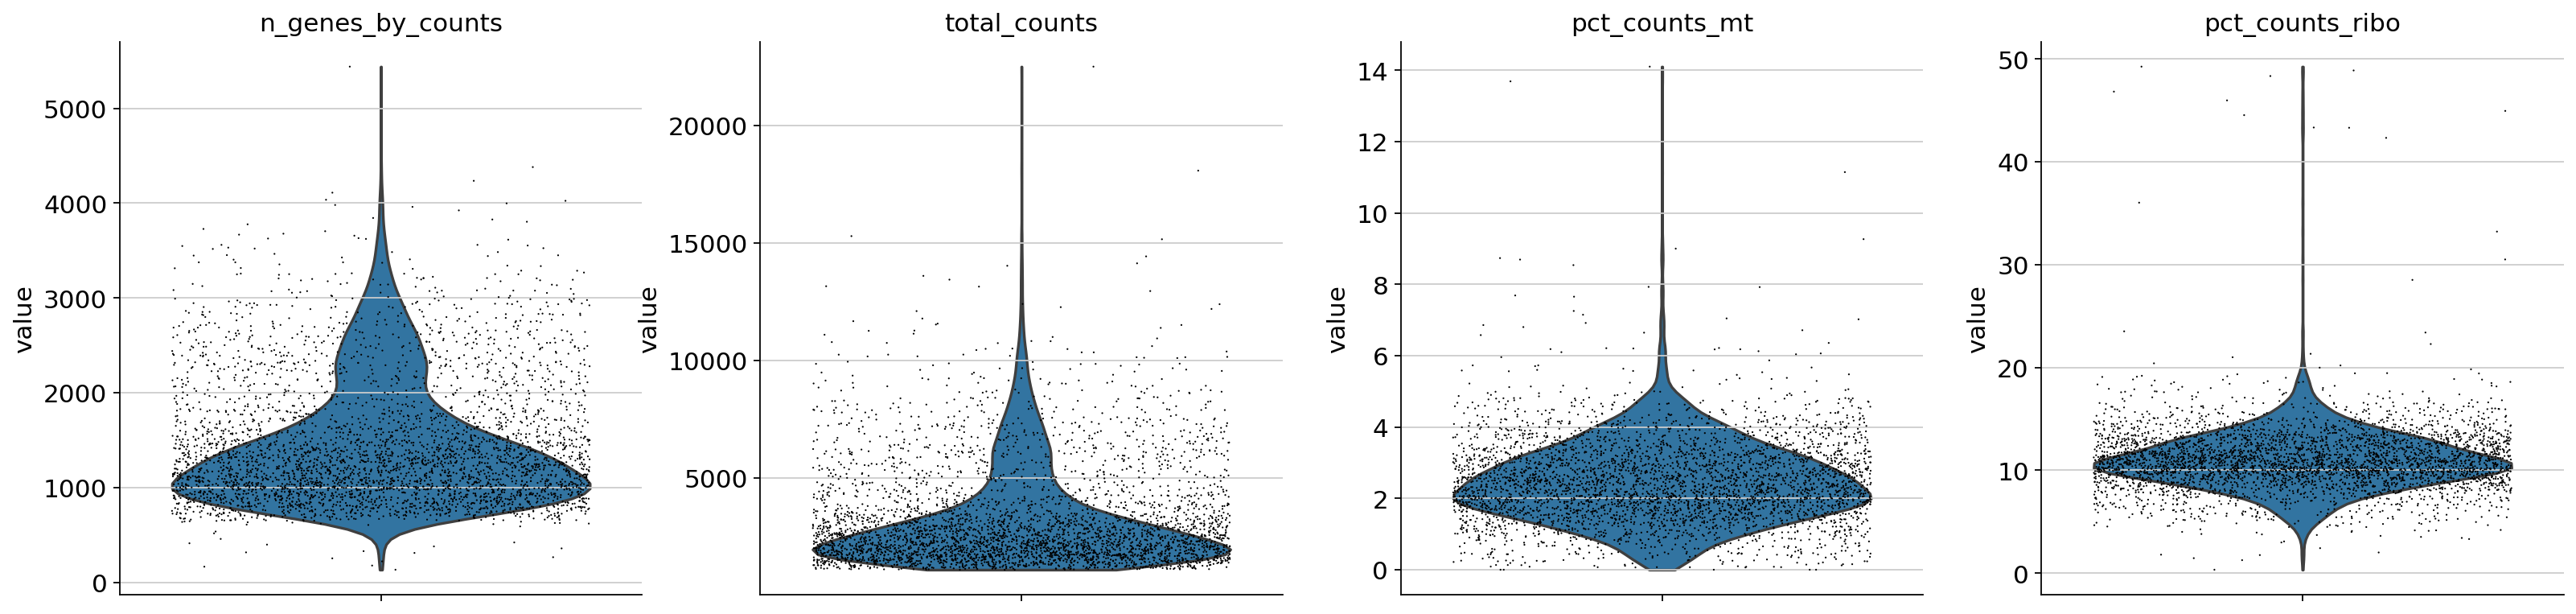

In [11]:
# A violin plot of some of the computed quality measures:
   # the number of genes expressed in the count matrix
   # the total counts per cell
   # the percentage of counts in mitochondrial genes

sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo'],
             jitter=0.4, multi_panel=True)

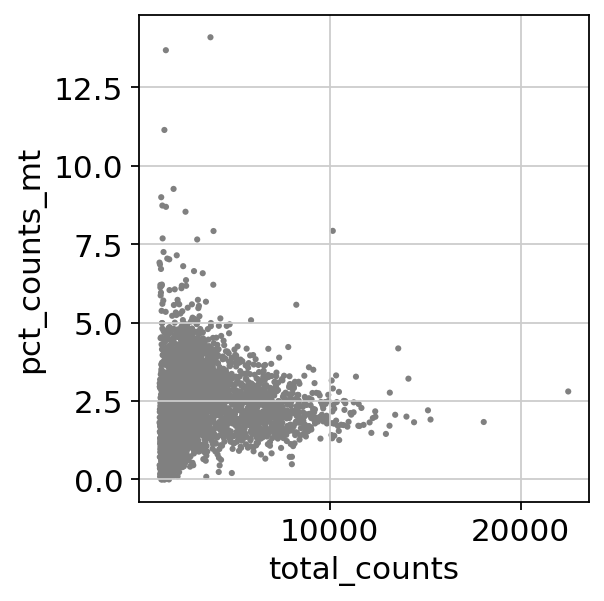

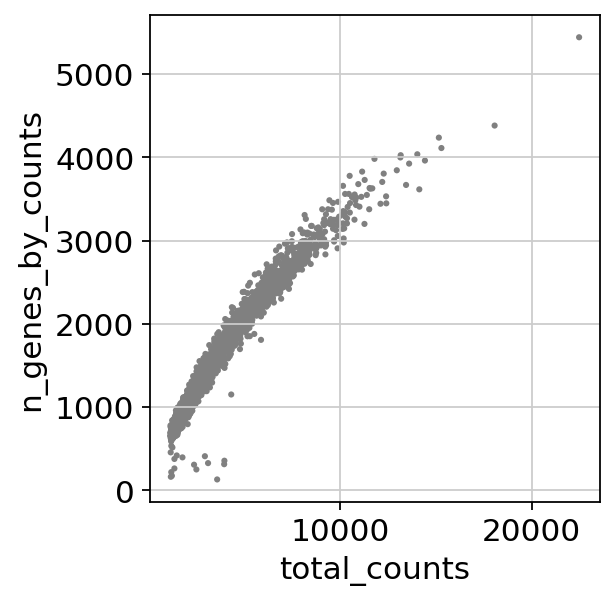

In [12]:
# Remove cells that have too many mitochondrial genes expressed or too many total counts:

sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [13]:
adata = adata[adata.obs.total_counts <= 12000]

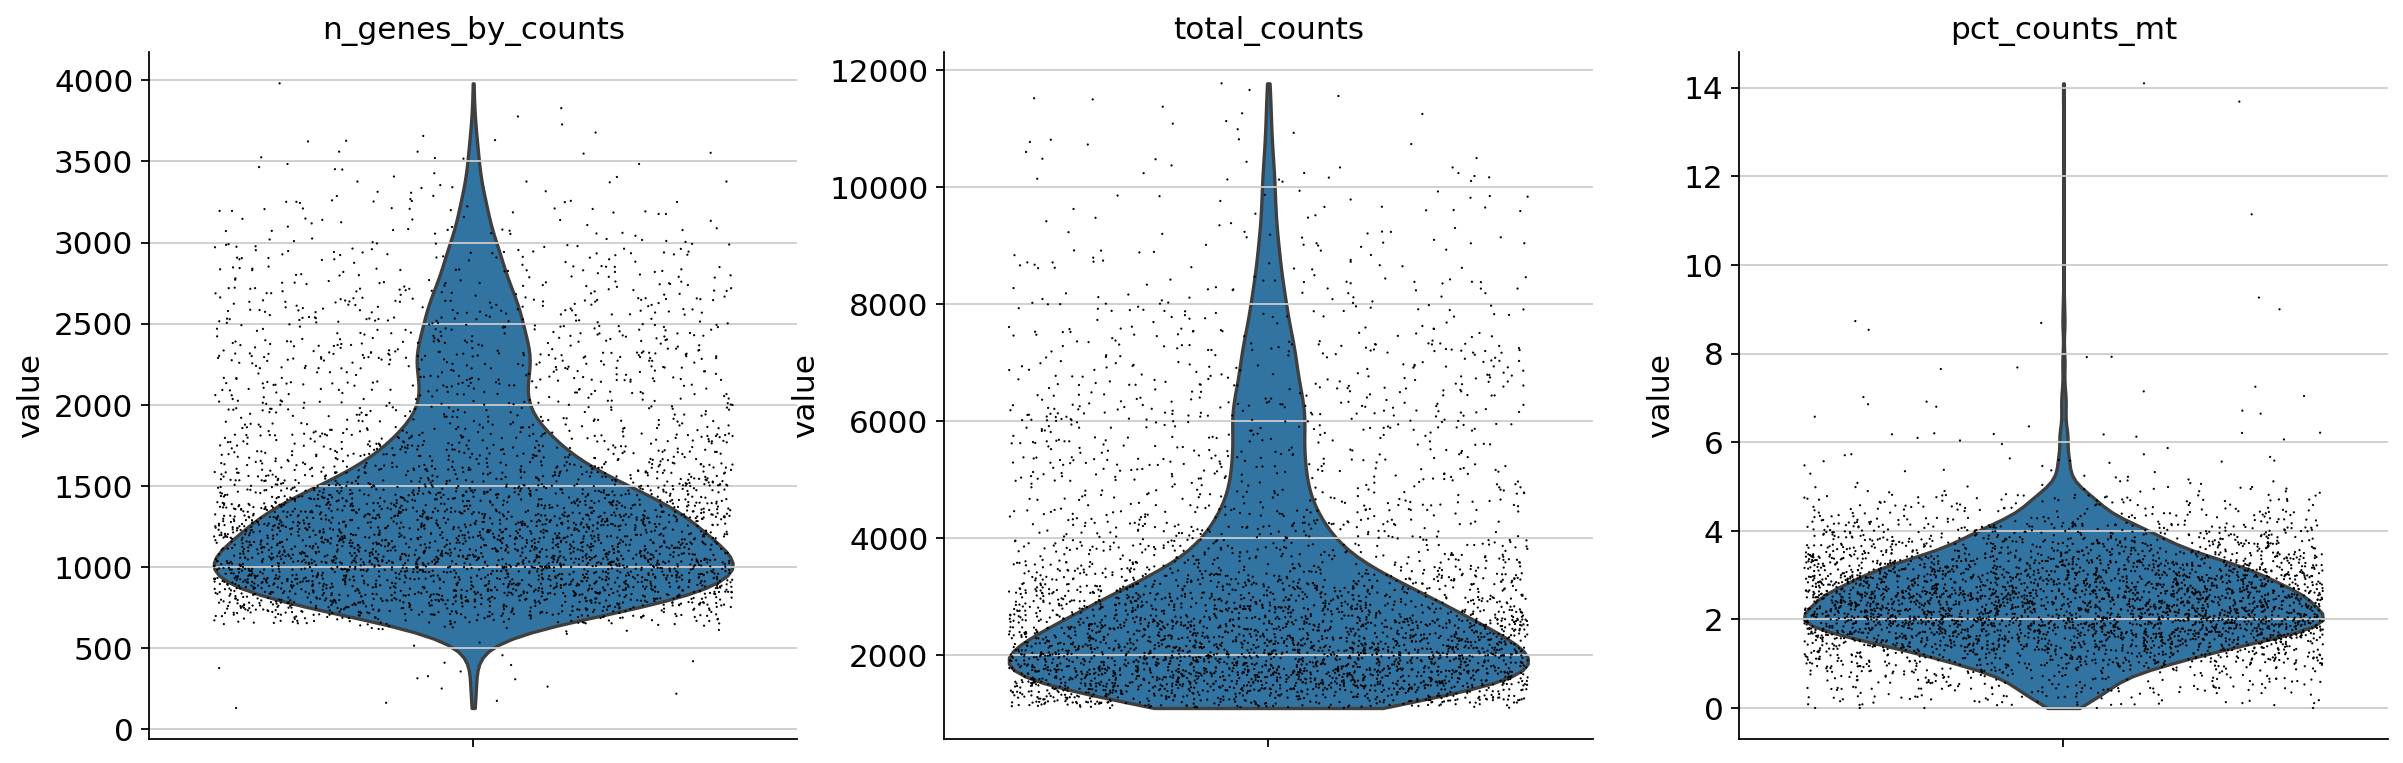

In [14]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

In [15]:
s_genes = pd.read_csv("/group/testa/Project/CBOProgPools/ReferenceFiles/S_genes",index_col=0,header=None)
g2m_genes = pd.read_csv("/group/testa/Project/CBOProgPools/ReferenceFiles/G2M_genes",index_col=0,header=None)
sc.tl.score_genes_cell_cycle(adata,s_genes.index,g2m_genes.index)

calculating cell cycle phase
computing score 'S_score'


Trying to set attribute `.obs` of view, copying.


    finished: added
    'S_score', score of gene set (adata.obs).
    899 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    857 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


In [16]:
adata.obs.keys()

Index(['n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt',
       'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'S_score',
       'G2M_score', 'phase'],
      dtype='object')

In [17]:
adata.obs.phase.value_counts()

G1     3509
G2M     202
S       181
Name: phase, dtype: int64

In [18]:
sc.external.pp.scrublet(adata)

Running Scrublet
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.27
Detected doublet rate = 1.7%
Estimated detectable doublet fraction = 37.9%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 4.5%
    Scrublet finished (0:00:08)


In [19]:
adata.obs.predicted_doublet.value_counts()

False    3826
True       66
Name: predicted_doublet, dtype: int64

In [20]:
adata.raw = adata.copy()
adata.layers['Raw'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=12000) # highest meaningful coverage (see tot_counts)
adata.layers['normalized'] = adata.X.copy()
sc.pp.log1p(adata)
adata.layers['logNorm'] = adata.X.copy()

normalizing counts per cell
    finished (0:00:00)


In [21]:
adata

AnnData object with n_obs × n_vars = 3892 × 11125
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'S_score', 'G2M_score', 'phase', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribo'
    uns: 'scrublet', 'log1p'
    layers: 'Raw', 'normalized', 'logNorm'

In [22]:
sc.pp.pca(adata, use_highly_variable=False)

sc.pp.neighbors(adata, metric='cosine', n_neighbors=int(0.5 * len(adata) ** 0.5)) #25 , 50. 75, 100
 
## Triku

tk.tl.triku(adata, use_raw=False)

Top20Triku = adata.var.sort_values(by=['triku_distance'], ascending=False).head(20).index
Top20Triku

computing PCA
    with n_comps=50
    finished (0:00:12)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)


Index(['AURKB', 'DLGAP5', 'CENPA', 'RRM2', 'PLK1', 'KIAA0101', 'ZWINT',
       'CDC20', 'ESCO2', 'KIF2C', 'TROAP', 'MKI67', 'CDCA2', 'KIF23', 'CKAP2L',
       'DIO2', 'KIFC1', 'TYMS', 'FAM107A', 'TFPI'],
      dtype='object')

In [23]:
adata.var_names[adata.var['highly_variable'] == True]

Index(['LINC00982', 'PRDM16', 'ACOT7', 'PER3', 'SRM', 'PDPN', 'KAZN', 'MFAP2',
       'IFI6', 'FABP3',
       ...
       'CYYR1', 'ADAMTS5', 'EVA1C', 'RCAN1', 'CBR3', 'CHAF1B', 'KCNJ6',
       'PSMG1', 'C21orf58', 'S100B'],
      dtype='object', length=1073)

# Principle Component Analysis

In [24]:
# Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main 
# axes of variation and denoises the data.
sc.tl.pca(adata, svd_solver='arpack',use_highly_variable=True)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


... storing 'phase' as categorical


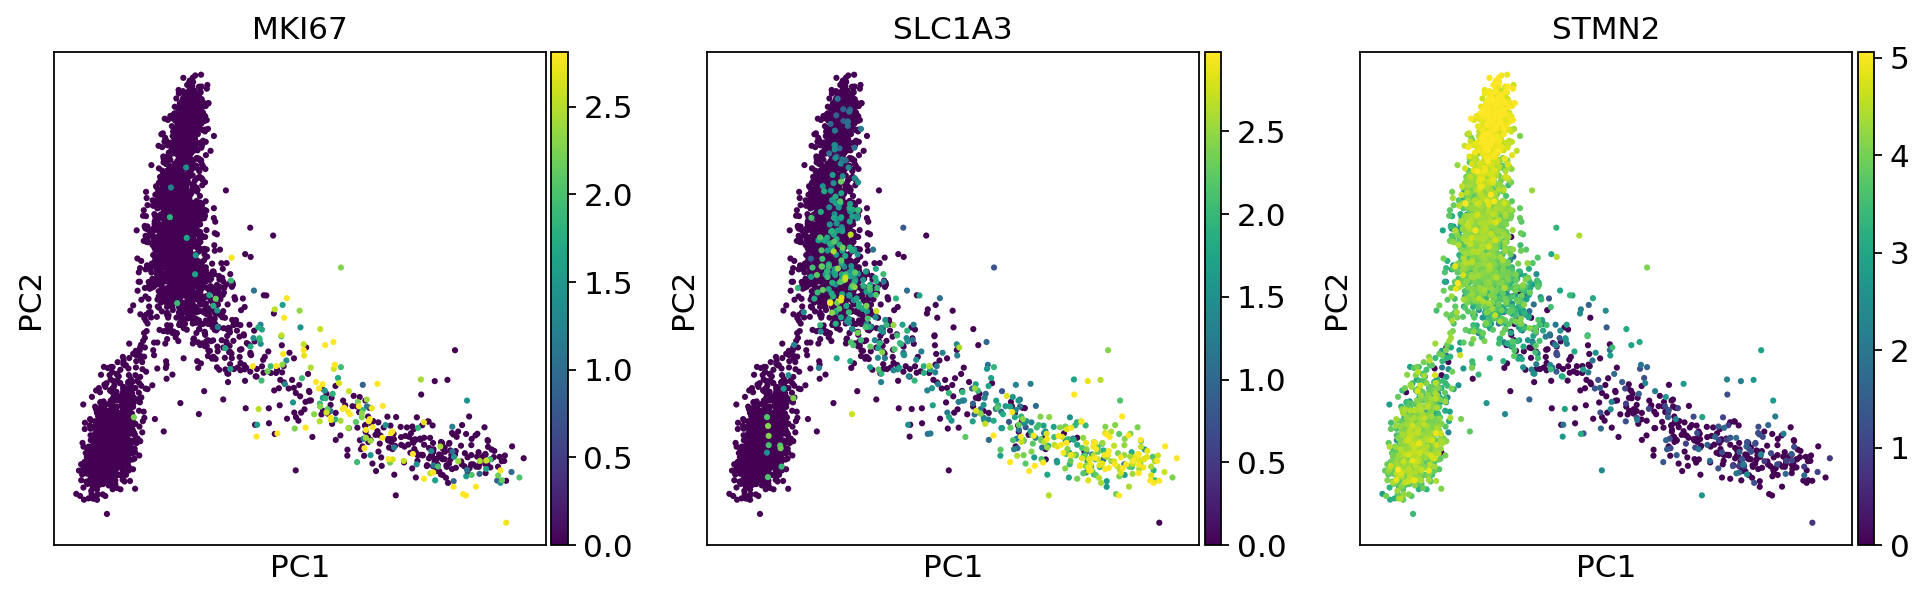

In [25]:

# MKI67 = cycling cell (usually progenitors, aRG / bRG / IP)
# EOMES = IP specific
# SLC1A3 = Radial Glia in general, including glia
# HOPX = bRG specific
# DCX = immature neurons
# STMN2 neurons in general

sc.pl.pca(adata, color=['MKI67','SLC1A3','STMN2'],use_raw=False,vmin="p1",vmax="p99") # 

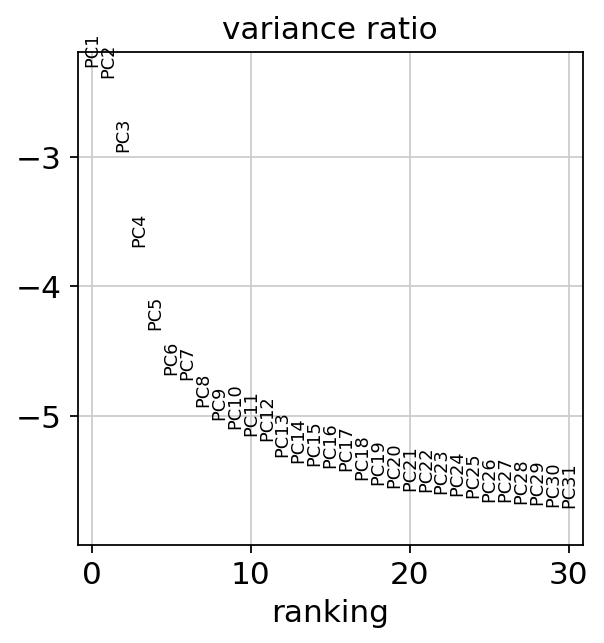

In [26]:
# Let us inspect the contribution of single PCs to the total variance in the data. 
# This gives us information about how many PCs we should consider in order to compute 
# the neighborhood relations of cells, e.g. used in the clustering function sc.tl.louvain() 
# or tSNE sc.tl.tsne(). In our experience, often a rough estimate of the number of PCs does fine.
sc.pl.pca_variance_ratio(adata, log=True)

In [27]:
# saving the result
adata.write(results_file)

In [28]:
adata

AnnData object with n_obs × n_vars = 3892 × 11125
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'S_score', 'G2M_score', 'phase', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribo', 'highly_variable', 'triku_distance', 'triku_distance_uncorrected', 'triku_highly_variable'
    uns: 'scrublet', 'log1p', 'pca', 'neighbors', 'triku_params'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'Raw', 'normalized', 'logNorm'
    obsp: 'distances', 'connectivities'

# Computing Neighborhood Graph 

In [29]:
int(0.5 * len(adata) ** 0.5)

31

In [30]:
# Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. 
# You might simply use default values here. For the sake of reproducing Seurat’s results, let’s take the following values.
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=10)

computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


# Embedding Neighborhood Graph

In [31]:
sc.tl.leiden(adata,resolution=0.5,key_added="leiden")
# small resolution ==> less clusters 
# 0.4 - 1.5

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [32]:
adata.obs.leiden.value_counts()

0    888
1    686
2    644
3    480
4    425
5    383
6    346
7     40
Name: leiden, dtype: int64

In [33]:
# We suggest embedding the graph in two dimensions using UMAP (McInnes et al., 2018), see below. 
# It is potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it 
# better preserves trajectories. In some ocassions, you might still observe disconnected clusters and
# similar connectivity violations. They can usually be remedied by running:
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


In [34]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


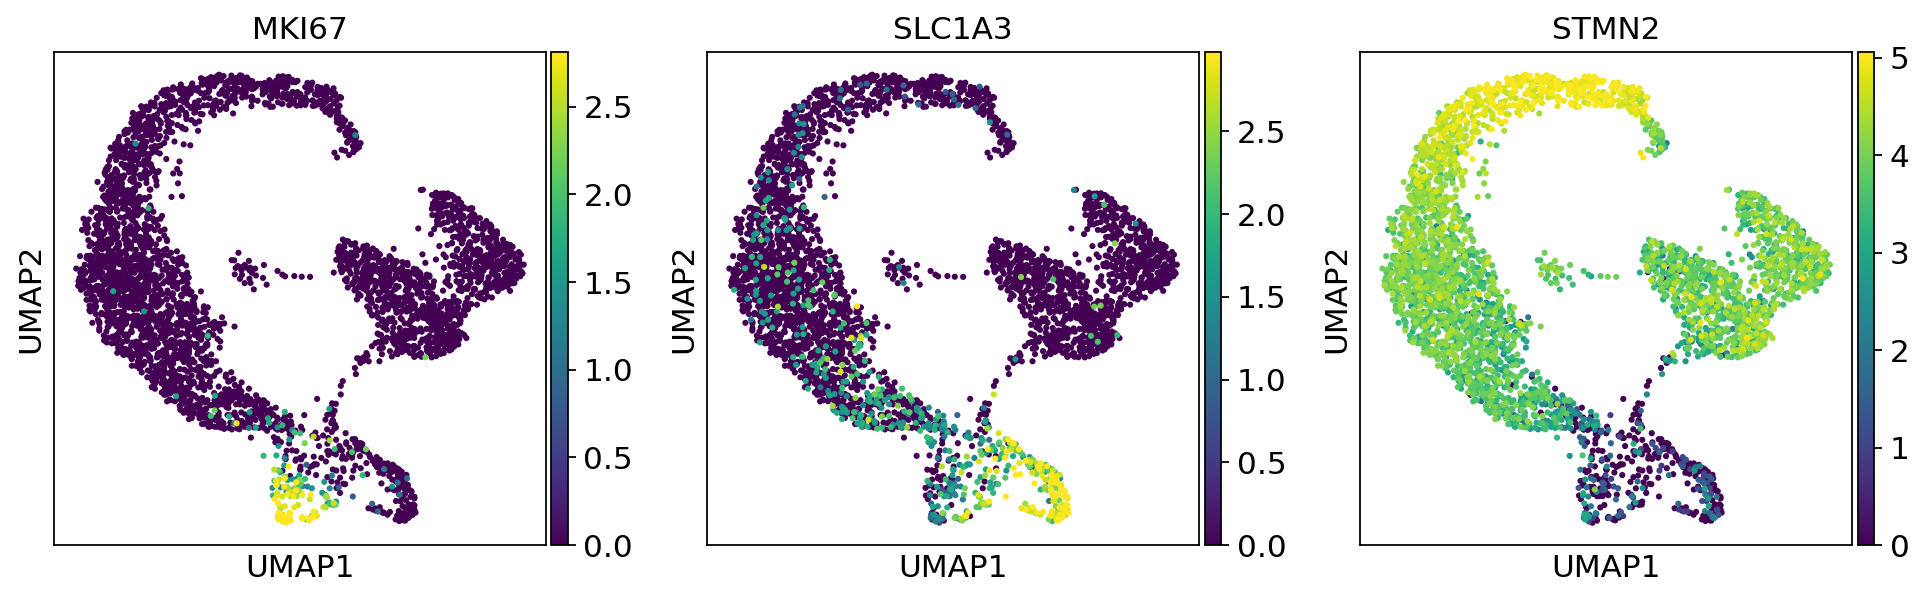

In [35]:
# As we set the .raw attribute of adata, the previous plots showed the “raw” (normalized, logarithmized, but uncorrected) 
# gene expression. You can also plot the scaled and corrected gene expression by explicitly stating that you don’t want to 
# use .raw.
sc.pl.umap(adata, color=['MKI67','SLC1A3','STMN2'], use_raw=False,vmin="p1",vmax="p99")

# Clustering Neighborhood Graph

In [36]:
# saving results
adata.write(results_file)

# Finding Gene Markers

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


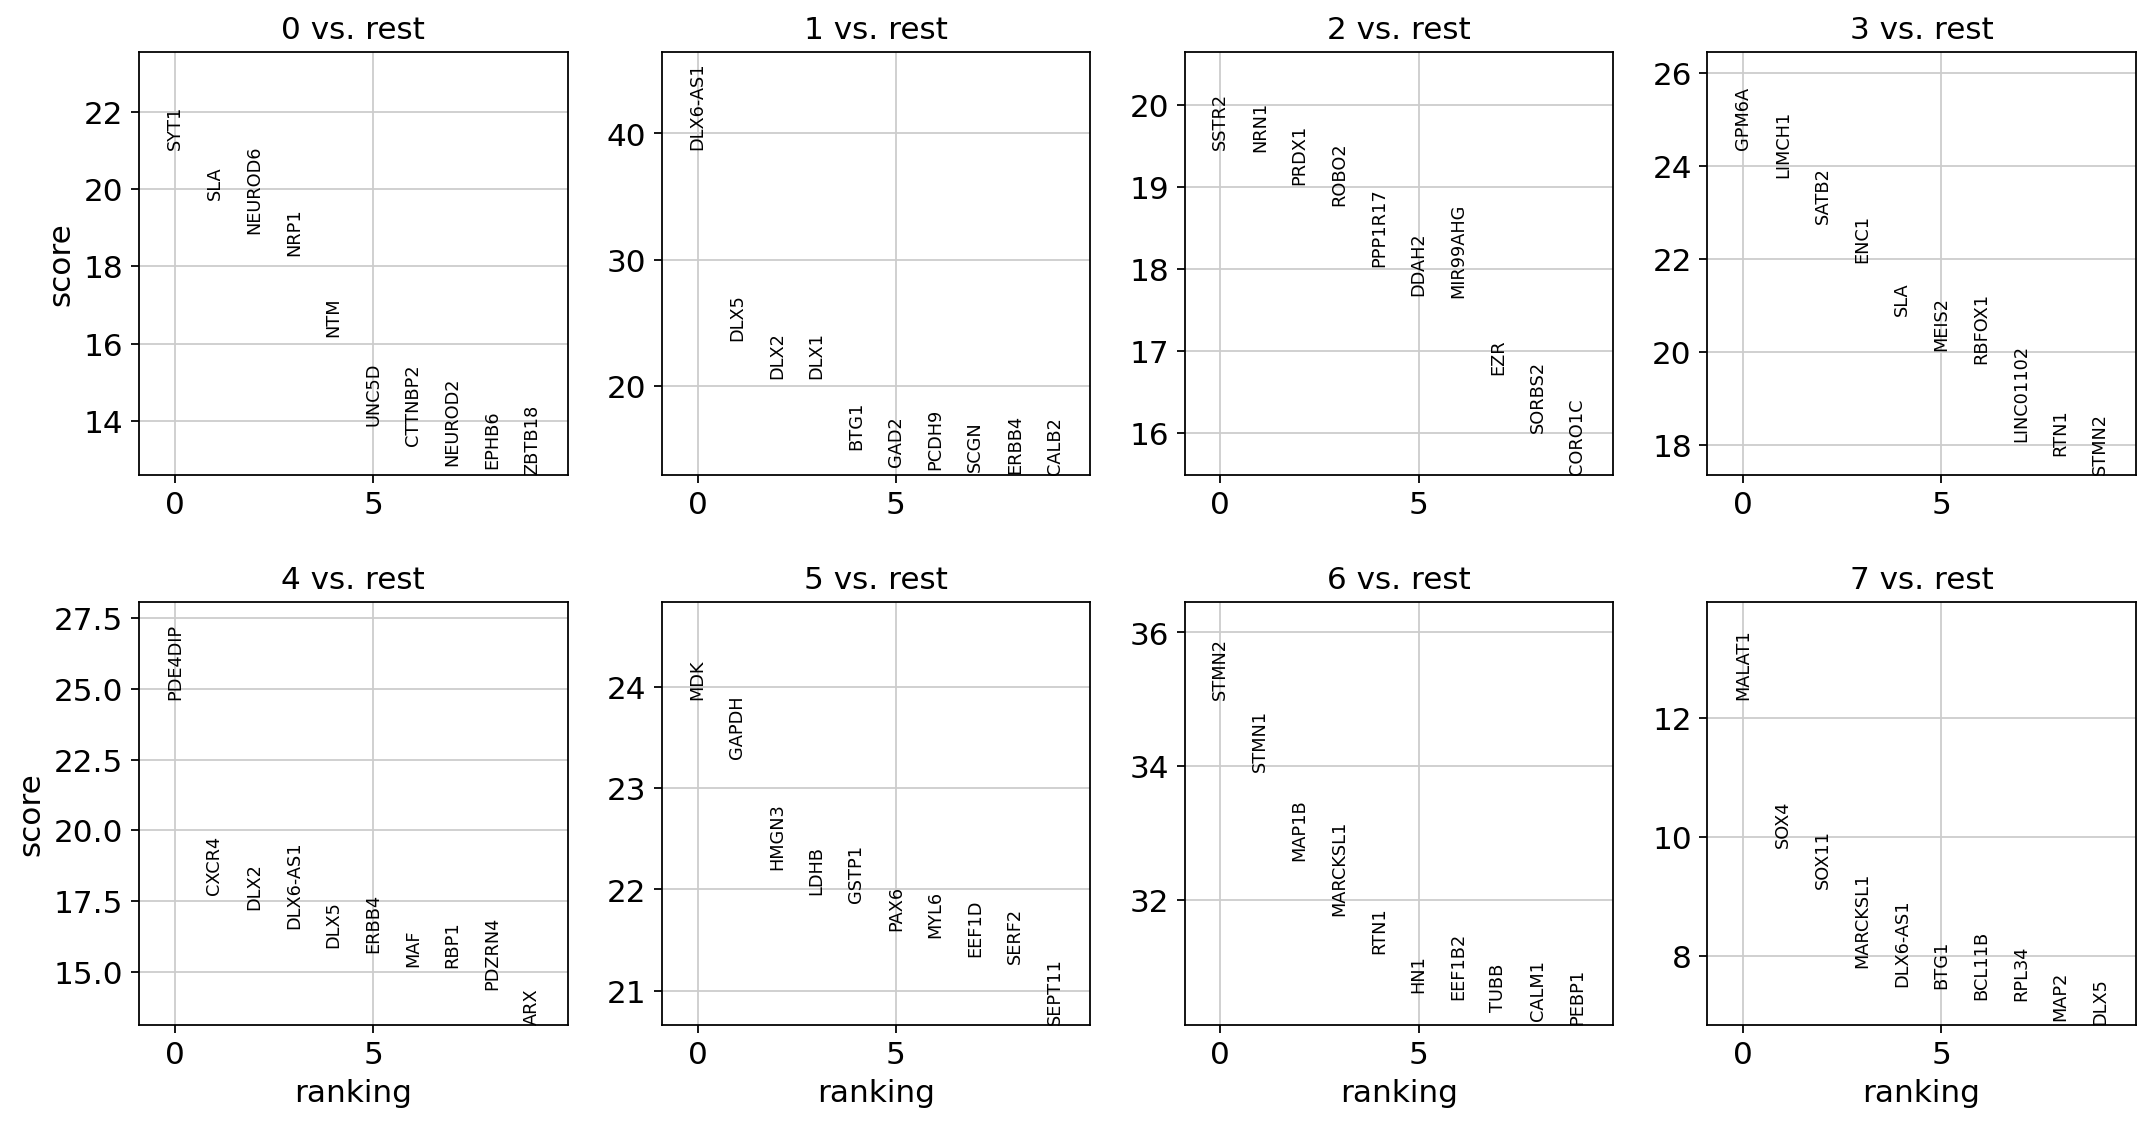

In [37]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False)

In [39]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

0_n           0_p       1_n            1_p      2_n           2_p  \
0     SYT1  1.675617e-84  DLX6-AS1  4.320384e-182    SSTR2  2.499797e-67   
1      SLA  6.645231e-78      DLX5   6.527257e-93     NRN1  4.789851e-67   
2  NEUROD6  3.057880e-71      DLX2   3.397993e-76    PRDX1  4.507009e-66   
3     NRP1  2.672811e-64      DLX1   7.892105e-75    ROBO2  6.472161e-65   
4      NTM  1.324374e-53      BTG1   2.659602e-45  PPP1R17  1.006162e-59   

      3_n           3_p       4_n           4_p    5_n           5_p  \
0   GPM6A  1.436529e-91   PDE4DIP  3.187747e-85    MDK  1.732384e-78   
1  LIMCH1  3.277902e-84     CXCR4  1.828529e-53  GAPDH  1.593089e-76   
2   SATB2  2.834632e-81      DLX2  1.623347e-51  HMGN3  4.411969e-71   
3    ENC1  1.900947e-76  DLX6-AS1  1.706749e-50   LDHB  5.218422e-71   
4     SLA  6.773619e-72      DLX5  9.565502e-46  GSTP1  3.873427e-70   

        6_n            6_p       7_n           7_p  
0     STMN2  5.010414e-117    MALAT1  2.523129e-15  
1     STMN1  5.823969e-113      SOX4  3.531720e-12  
2     MAP1B  9.400867e-109     SOX11  2.430120e-11  
3  MARCKSL1  1.045598e-106  MARCKSL1  1.136228e-09  
4      RTN1  8.726486e-105  DLX6-AS1  4.246670e-09

In [40]:
adata.write(results_file)

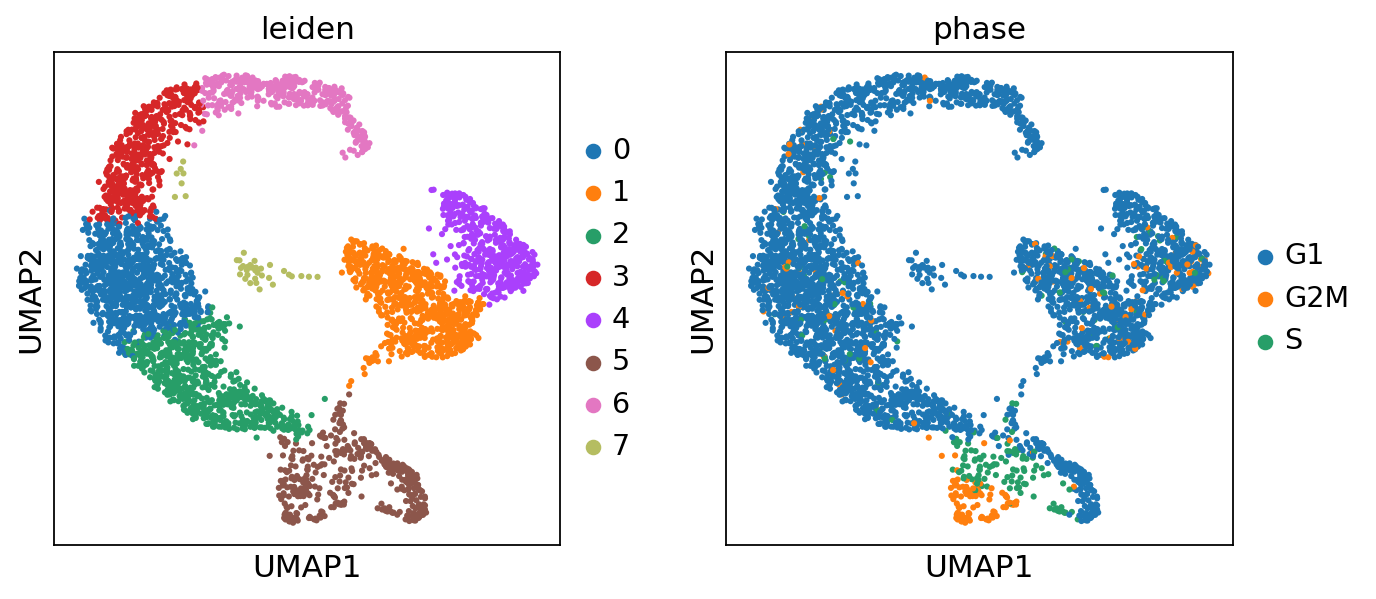

In [41]:
sc.pl.umap(adata,color=["leiden","phase"])

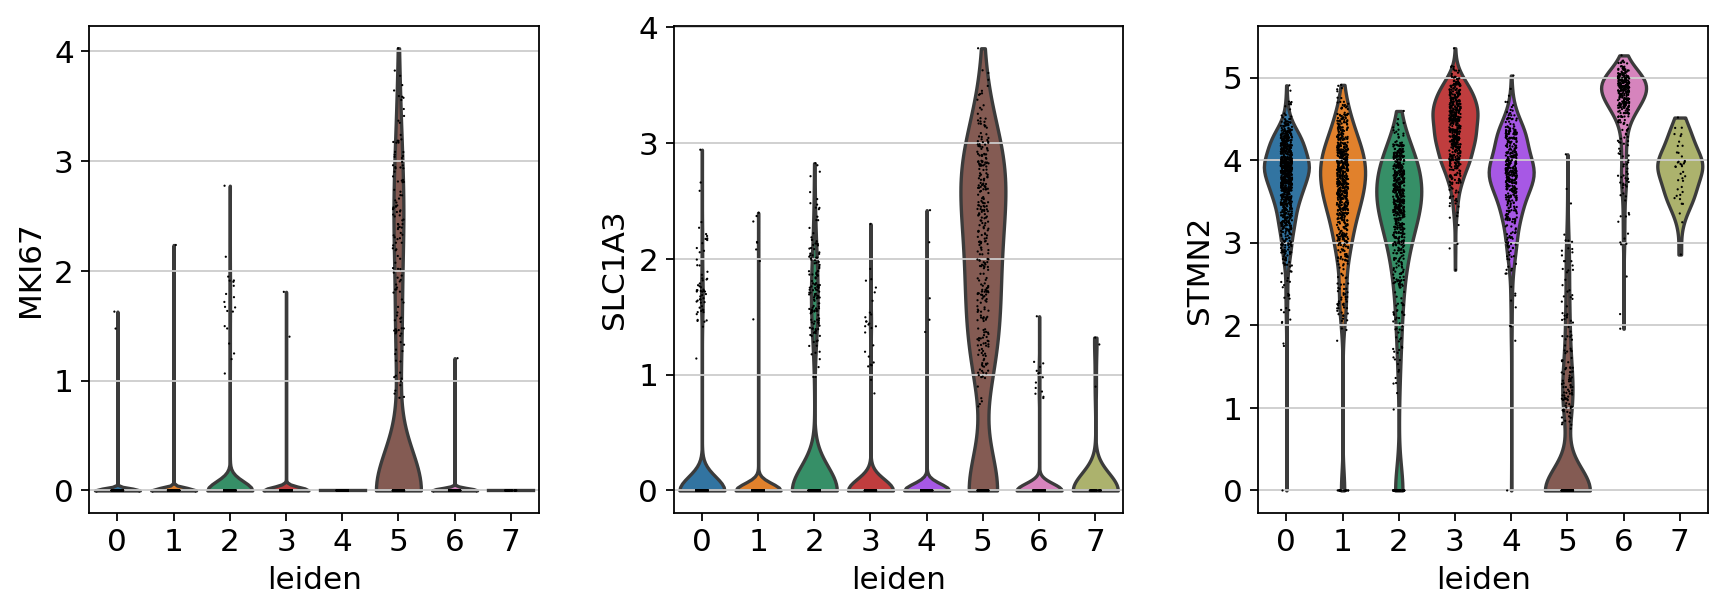

In [42]:
sc.pl.violin(adata, ['MKI67', 'SLC1A3','STMN2'], groupby='leiden',use_raw=False)

In [43]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)

0         1         2          3         4       5         6  \
0     SYT1  DLX6-AS1     SSTR2      GPM6A   PDE4DIP     MDK     STMN2   
1      SLA      DLX5      NRN1     LIMCH1     CXCR4   GAPDH     STMN1   
2  NEUROD6      DLX2     PRDX1      SATB2      DLX2   HMGN3     MAP1B   
3     NRP1      DLX1     ROBO2       ENC1  DLX6-AS1    LDHB  MARCKSL1   
4      NTM      BTG1   PPP1R17        SLA      DLX5   GSTP1      RTN1   
5    UNC5D      GAD2     DDAH2      MEIS2     ERBB4    PAX6       HN1   
6  CTTNBP2     PCDH9  MIR99AHG     RBFOX1       MAF    MYL6    EEF1B2   
7  NEUROD2      SCGN       EZR  LINC01102      RBP1   EEF1D      TUBB   
8    EPHB6     ERBB4    SORBS2       RTN1    PDZRN4   SERF2     CALM1   
9   ZBTB18     CALB2    CORO1C      STMN2       ARX  SEPT11     PEBP1   

          7  
0    MALAT1  
1      SOX4  
2     SOX11  
3  MARCKSL1  
4  DLX6-AS1  
5      BTG1  
6    BCL11B  
7     RPL34  
8      MAP2  
9      DLX5

In [44]:
marker_genes = ['leiden','SYT1', 'DLX5','SSTR2','LIMCH1','CXCR4','MDK','STMN1','SOX4']

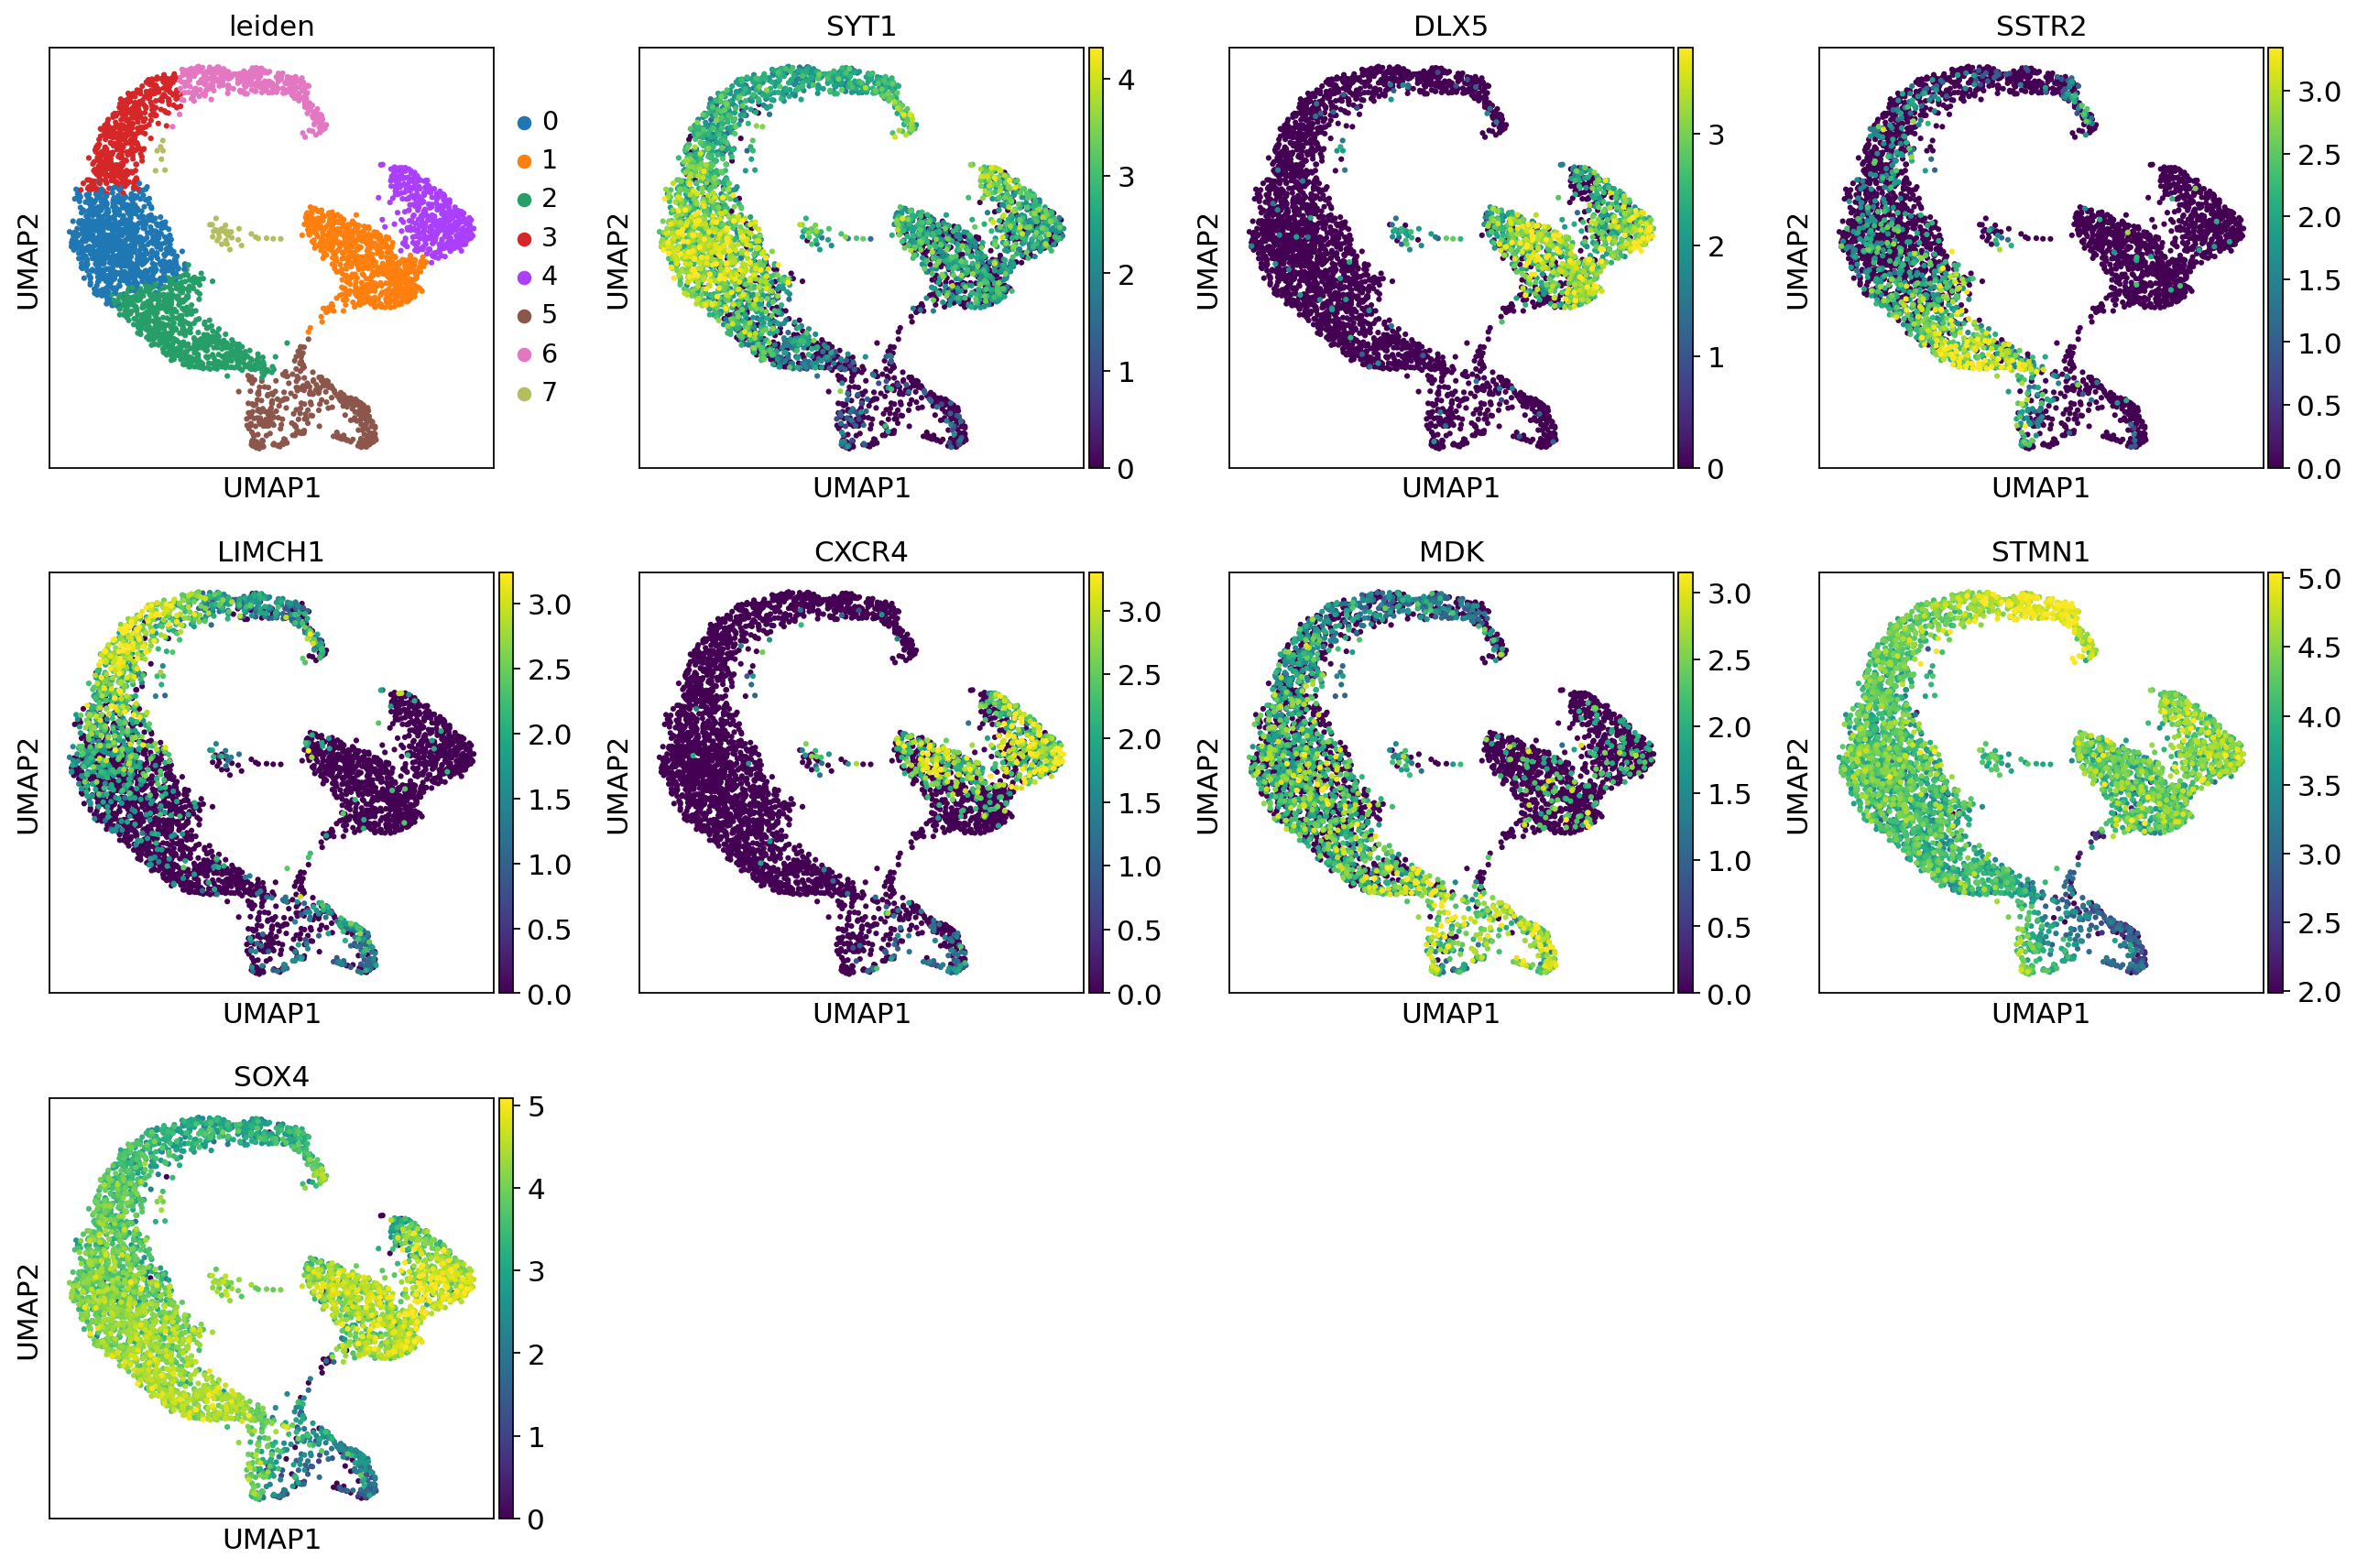

In [45]:
sc.pl.umap(adata,color=marker_genes,vmin="p1",vmax="p99",use_raw=False)

In [46]:
sc.tl.diffmap(adata)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9971979  0.99580574 0.9932054  0.98213696 0.97924745
     0.97485363 0.9721716  0.95976025 0.955432   0.9487811  0.9445535
     0.93820536 0.92956173 0.9237393 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


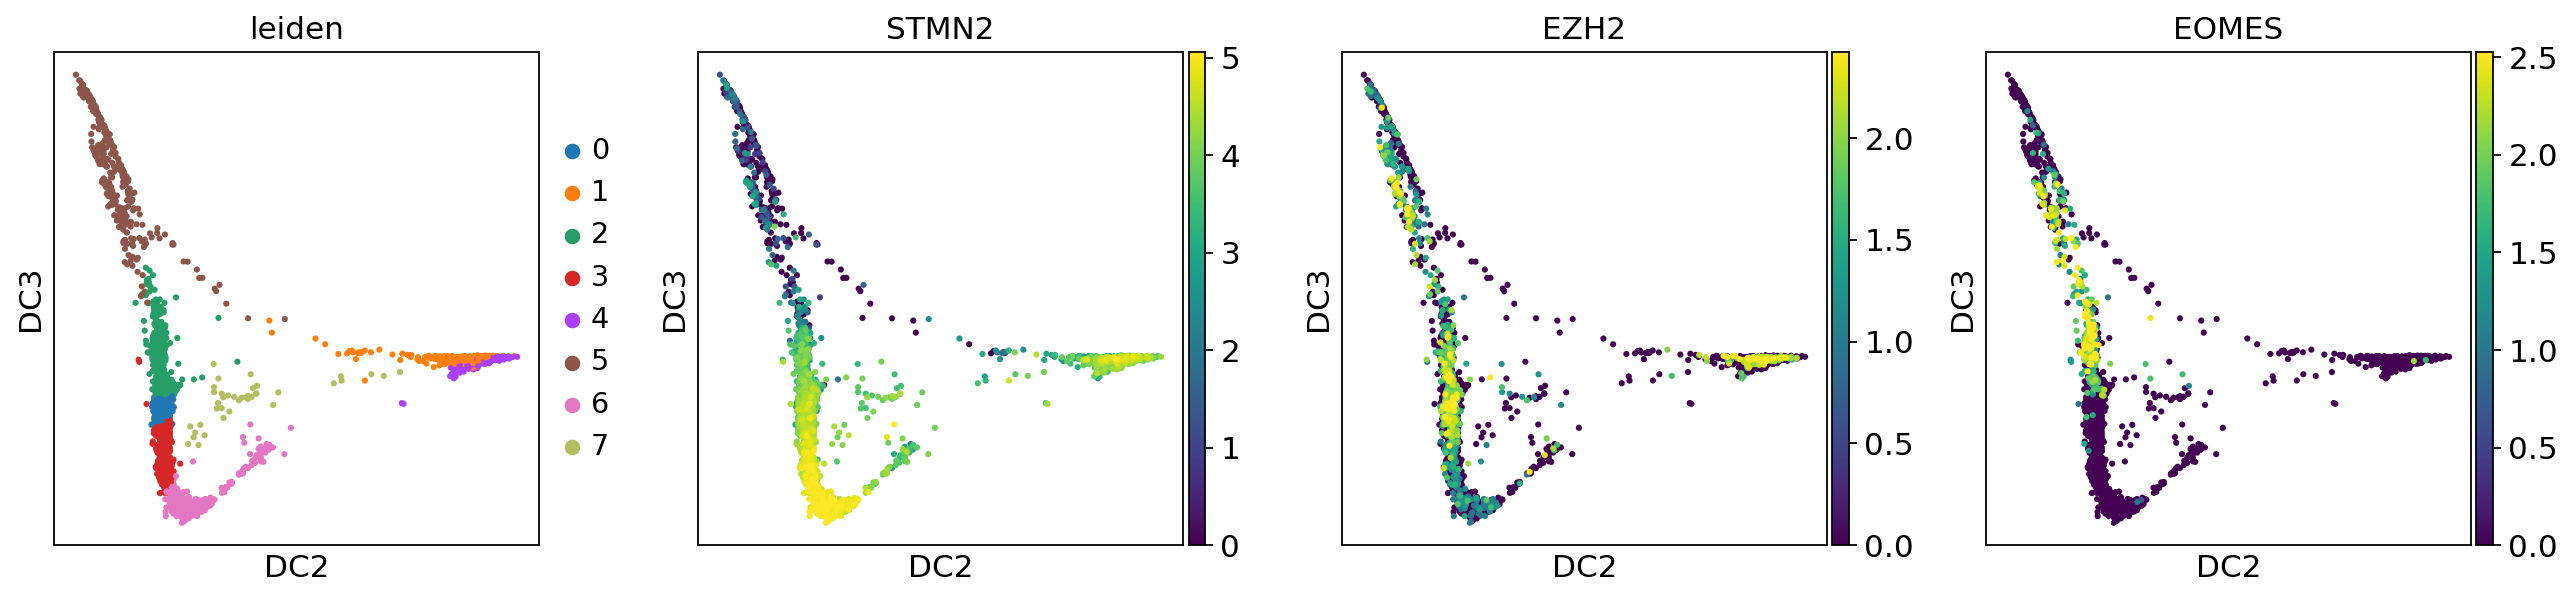

In [47]:
sc.pl.diffmap(adata,color=["leiden", 'STMN2','EZH2', 'EOMES'],dimensions=(1,2),vmin='p1',vmax='p99',use_raw=False)

In [48]:
#adata = adata[~adata.obs.leiden.isin(['XXX'])].copy()

In [49]:
sc.tl.leiden(adata,resolution=0.5,key_added="leiden")

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`
categories: 0, 1, 2, etc.
var_group_labels: astrocytes, endothelial, ExcDeepLayer, etc.


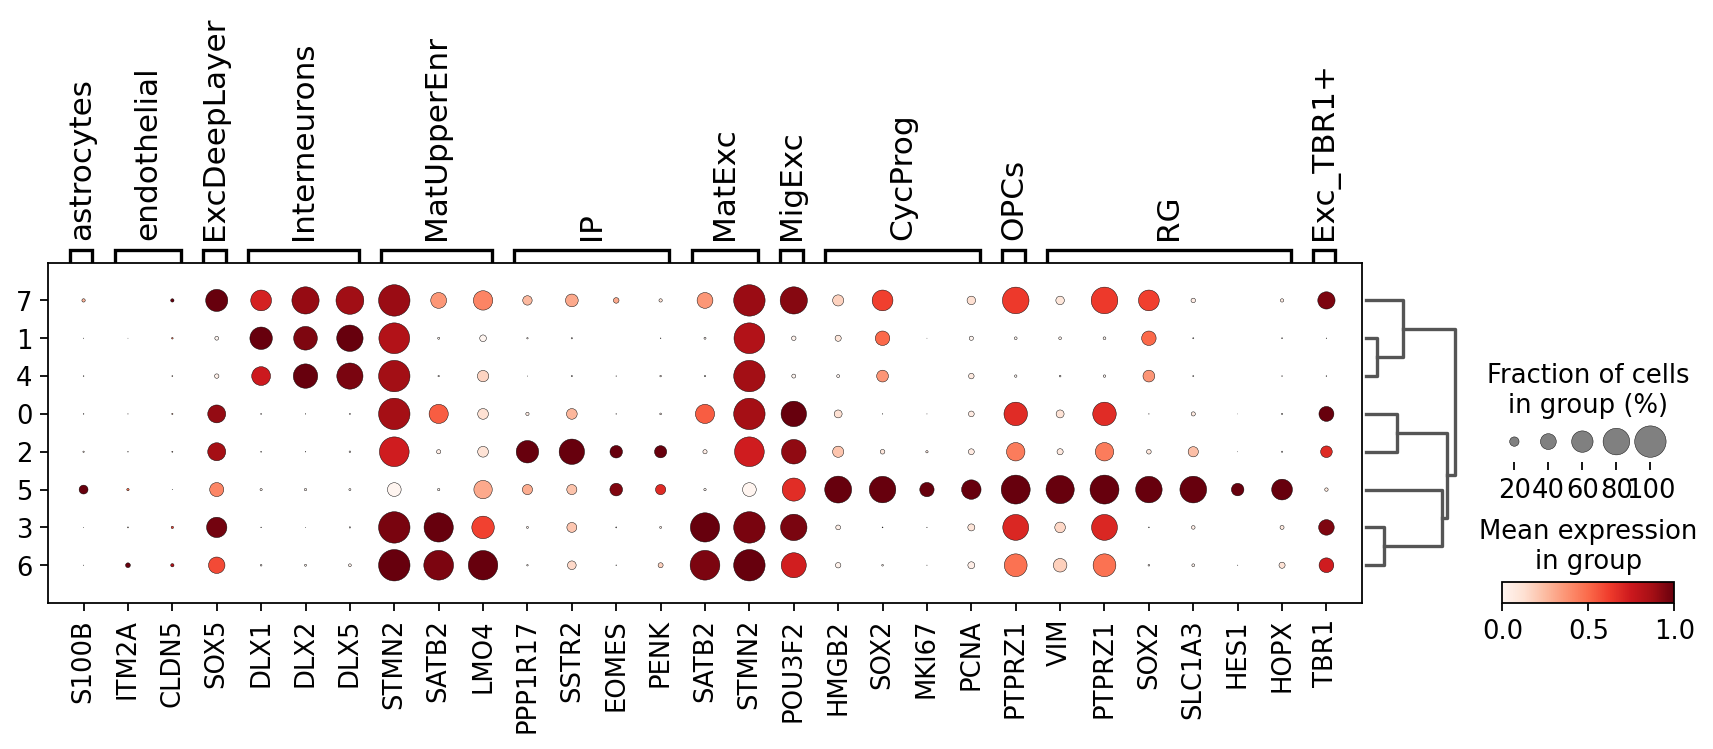

In [50]:
geschwind_ext = {
  'astrocytes' : ['S100B'],
  'endothelial' : ['ITM2A','CLDN5'],
  'ExcDeepLayer' : ['SOX5'],
  'Interneurons' : ['DLX1','DLX2','DLX5'],
  'MatUpperEnr' : ['STMN2','SATB2','LMO4'],
  'IP' : ['PPP1R17','SSTR2','EOMES','PENK'],
  'MatExc' : ['SATB2','STMN2'],
  'MigExc' : ['POU3F2'],
  'CycProg' : ['HMGB2','SOX2','MKI67','PCNA'],
  'OPCs' : ['PTPRZ1'],
  'RG' : ['VIM','PTPRZ1','SOX2','SLC1A3','HES1','HOPX'],
  'Exc_TBR1+' : ['TBR1']
}

sc.pl.dotplot(adata,geschwind_ext , 'leiden', dendrogram=True,save="combo_markersDotplot",use_raw=False,log=True,standard_scale='var')

In [51]:
cluster2annotation = {
     "0": "Neu", "1": "Neu","2":"Neu", "3": "Neu",
    "4": "Neu", "5" : "RG", "6": "Neu", "7": "Neu"
}
 
adata.obs['celltype'] = adata.obs['leiden'].map(cluster2annotation).astype('category')

In [52]:

cluster2annotation = {
     "0": "DeepLayer", "1": "Interneuron","2":"DeepLayer/IP", "3": "Mig/Mat",
    "4": "Interneuron", "5" : "oRG", "6": "Mig/Mat", "7": "DeepLayer"
}
 
adata.obs['celltype2'] = adata.obs['leiden'].map(cluster2annotation).astype('category')

In [53]:
new_cluster_names = [
    '0/DeepLayer', '1/Interneuron',
    '2/DeepLayer/IP', '3/Mig/Mat',
    '4/Interneuron','5/oRG',
    '6/Mig/Mat', '7/DeepLayer']
adata.rename_categories('leiden', new_cluster_names)

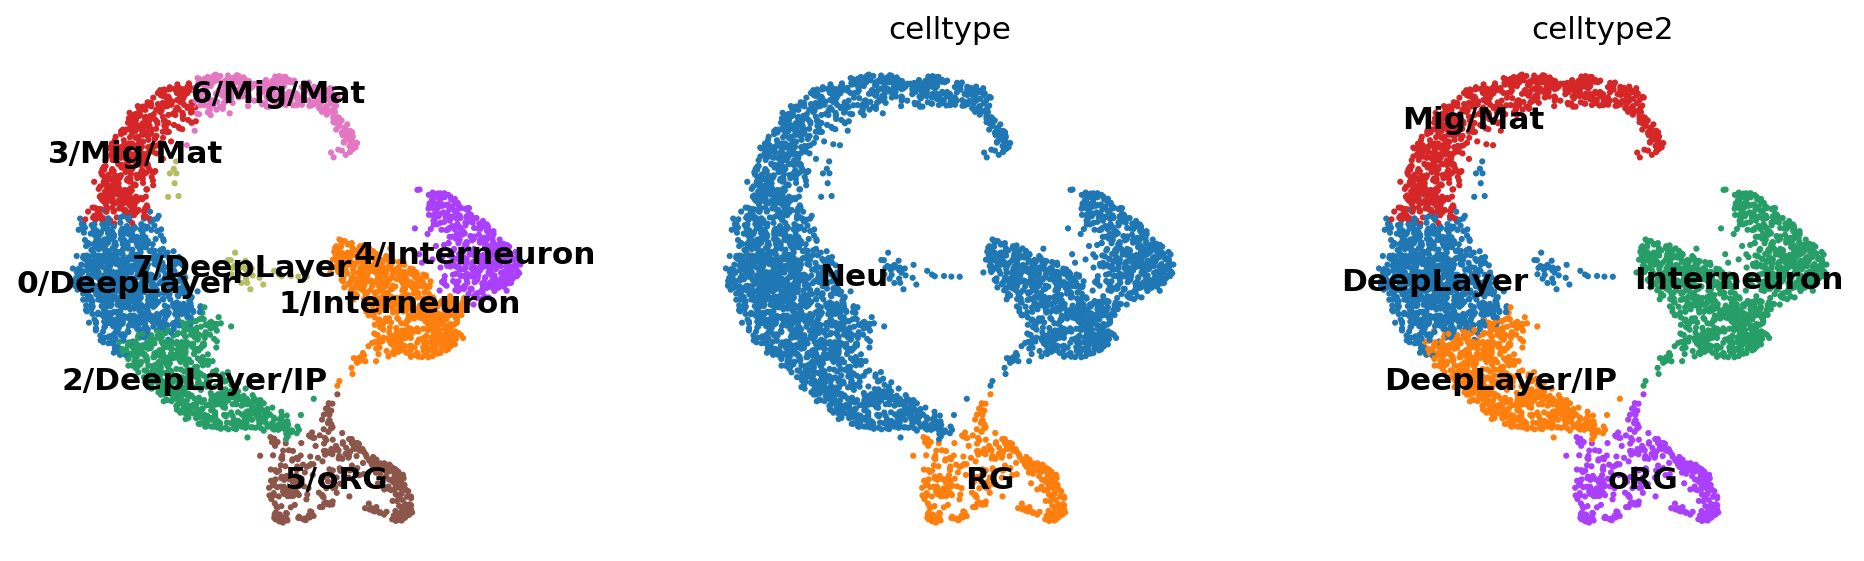

In [54]:
sc.pl.umap(adata, color=['leiden','celltype','celltype2'], legend_loc='on data', title='', frameon=False, save='.pdf')

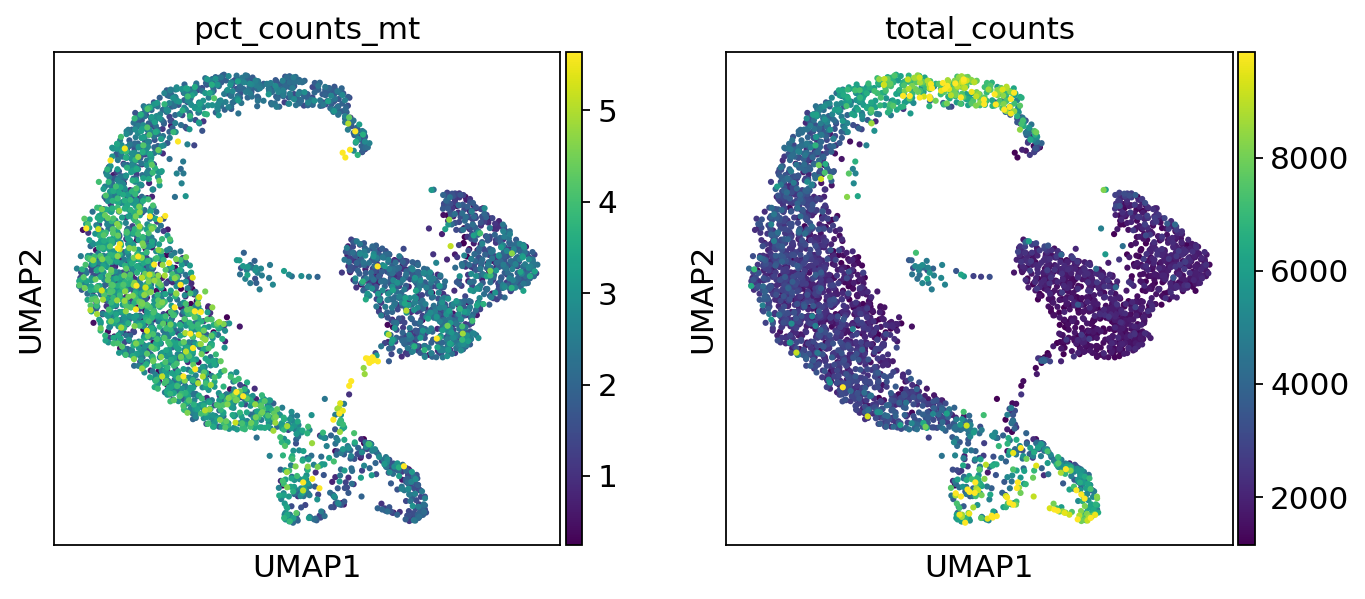

In [55]:
sc.pl.umap(adata,color=['pct_counts_mt','total_counts'],vmin='p1',vmax='p99')

In [56]:
sc.tl.dendrogram(adata,"leiden")

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


In [57]:
sc.tl.diffmap(adata)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9971979  0.99580574 0.9932054  0.98213696 0.97924745
     0.97485363 0.9721716  0.95976025 0.955432   0.9487811  0.9445535
     0.93820536 0.92956173 0.9237393 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


In [58]:
adata.obs.leiden.value_counts()

0/DeepLayer       888
1/Interneuron     686
2/DeepLayer/IP    644
3/Mig/Mat         480
4/Interneuron     425
5/oRG             383
6/Mig/Mat         346
7/DeepLayer        40
Name: leiden, dtype: int64

In [60]:
sc.tl.diffmap(adata)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9971979  0.99580574 0.9932054  0.98213696 0.97924745
     0.97485363 0.9721716  0.95976025 0.955432   0.9487811  0.9445535
     0.93820536 0.92956173 0.9237393 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


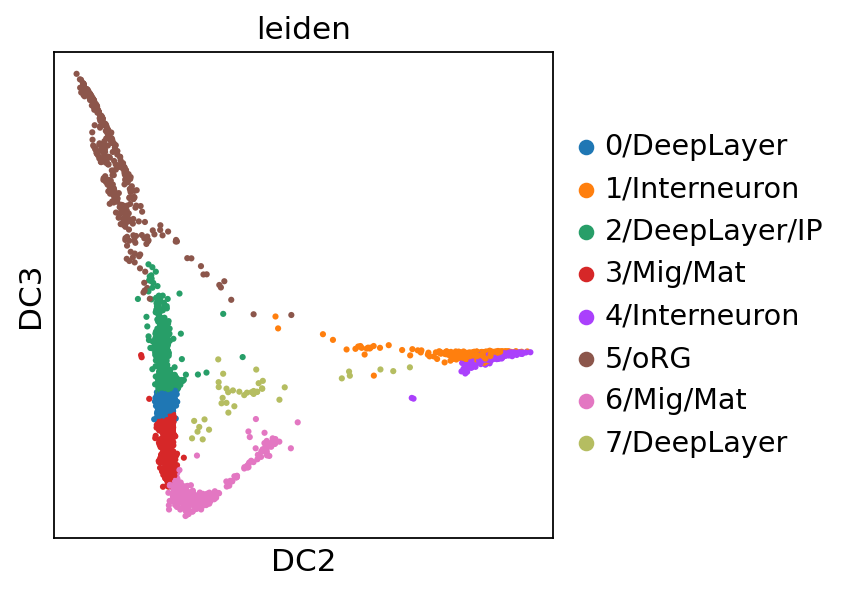

In [61]:
sc.pl.diffmap(adata,color="leiden",dimensions=(1,2))

In [62]:
adata.obs.leiden

AAACCTGAGCGCCTCA-1    2/DeepLayer/IP
AAACCTGAGCTGTTCA-1       0/DeepLayer
AAACCTGAGTAATCCC-1     1/Interneuron
AAACCTGCAAGCGAGT-1    2/DeepLayer/IP
AAACCTGCAATCCGAT-1     1/Interneuron
                           ...      
TTTGTCAGTACAAGTA-1     1/Interneuron
TTTGTCAGTGCGGTAA-1     1/Interneuron
TTTGTCATCACCATAG-1             5/oRG
TTTGTCATCATGTCCC-1     1/Interneuron
TTTGTCATCGGAGGTA-1     1/Interneuron
Name: leiden, Length: 3892, dtype: category
Categories (8, object): ['0/DeepLayer', '1/Interneuron', '2/DeepLayer/IP', '3/Mig/Mat', '4/Interneuron', '5/oRG', '6/Mig/Mat', '7/DeepLayer']

In [63]:
adata.write_h5ad("/group/testa/Project/CBOProgPools/h5ad/GW19_02_20240209_v1.h5ad")

In [3]:
adata=sc.read_h5ad("/group/testa/Project/CBOProgPools/h5ad/GW19_02_20240209_v1.h5ad")

In [4]:
adata.obs['stage'] = 'GW19'

In [5]:
adata.write_h5ad('/group/testa/Project/CBOProgPools/h5ad/GW19_02_20240209_v1.h5ad')